# Wiberg bond order in "aromatic" compounds

In [1]:
#!/usr/bin/env python
from openeye import oechem, oedepict, oeomega, oequacpac
from IPython.display import display
import oenotebook as oenb
import pandas as pd
from openmoltools.openeye import get_charges
from openforcefield.typing.engines.smirnoff import forcefield
from openforcefield.typing.engines.smirnoff.forcefield import getSMIRKSMatches_OEMol

In [2]:
def depict_bridge(mol_copy, width=400, height=400):
    """
    Provides an image of a molecule where the bond for that row is hilighted
    It is expected to be used to display a molecule in a pandas dataframe with oenotebook
    """
    mol = oechem.OEMol(mol_copy)
    
    atomBondSet = oechem.OEAtomBondSet()
    for bond in mol.GetBonds():
        if bond.HasData('highlight'):
            atomBondSet.AddBond( bond)

    dopt = oedepict.OEPrepareDepictionOptions()
    dopt.SetSuppressHydrogens(True)
    oedepict.OEPrepareDepiction(mol, dopt)
    
    opts = oedepict.OE2DMolDisplayOptions(width, height, oedepict.OEScale_AutoScale)
    opts.SetTitleLocation(oedepict.OETitleLocation_Hidden)
    
    disp = oedepict.OE2DMolDisplay(mol, opts)

    hstyle = oedepict.OEHighlightStyle_BallAndStick
    hcolor = oechem.OEColor(oechem.OELightBlue)
    oedepict.OEAddHighlighting(disp, hcolor, hstyle, atomBondSet)

    img = oedepict.OEImage(width, height)
    oedepict.OERenderMolecule(img, disp)
    return oenb.draw_oeimage_to_img_tag(img)

In [3]:
def get_mol(smiles):
    """
    Returns an OEMol with 3D conformers and AM1-BCC charges 
    this is done with the method 'get_charges' from openmoltools.openeye
    
    Parameters
    ----------
    smiles - SMILES string to create the molecule
    """
    m = oechem.OEMol()
    oechem.OESmilesToMol(m, smiles)
    return get_charges(m, keep_confs=1)

In [4]:
def get_order_by_indice(input_mol, a1, a2):
    """
    returns bond order for bond between index a1 and a2
    
    """
    mol = oechem.OEMol(input_mol)
    atom1 = mol.GetAtom(oechem.OEHasAtomIdx(a1))
    atom2 = mol.GetAtom(oechem.OEHasAtomIdx(a2))
    bond = mol.GetBond(atom1, atom2)
    bond.SetData('highlight', True)
    return mol, bond.GetData('WibergBondOrder')

In [5]:
def get_bond_indices(mol, smirks='[*:1]@[*:2]'):
    bond_set = set()
    for (a1, a2) in getSMIRKSMatches_OEMol(m, smirks):
        if a1 > a2:
            bond_set.add((a2,a1))
        else:
            bond_set.add((a1,a2))
    return bond_set

# -----------------------------------------------

In [10]:
# provide a list of SMILES for molecules chemists typically think of as aromatic
aromatics = [
    ('C1=CNC=N1', 'imidazole'),
    ('C1=COC=N1', 'oxazole'),
    ('C1=CNC=C1', 'pyrrole'),
    ('C1=CN(C)C=C1', 'methyl_pyrrole'),
    ('C1=CC=CC=C1', 'benzene'),
    ('N1=CC=CC=C1', 'pyridine'),
]

In [11]:
# Create a pandas dataframe to store information about each molecule
# This is a convenient format as it allows easy visualization of molecules with oenotebook
df = pd.DataFrame(columns=['smiles', 'name', 'Molecule', 'bond_order'])

for (smi, name) in aromatics:
    m = get_mol(smi)
    # create a dictionary to store information about the molecule to later append to the dataframe
    info_dict = {
        'smiles': smi, 'name': name
    }
    
    bond_indices = get_bond_indices(m)
    for (a1, a2) in bond_indices:
        # For each ring bond highlight the bond and show the bond order
        info_dict['Molecule'], info_dict['bond_order'] = get_order_by_indice(m, a1, a2)
        df = df.append(pd.Series(info_dict), ignore_index=True)

df.sort_values(['smiles', 'bond_order'], inplace=True)


### Visualization

Each ring bond in each molecule has its own row. The bond is highlighted and the bond order is shown. 
For each molecule the rows are sorted from smallest bond order to largest. 
You will see that for benzene and pyridine all six bonds have a bond order of around 1.4. 
However, for the five-membered rings, the "single" bonds have a bond order around 1.2 and the "double" bonds are around 1.6.
This is evidence that there is conjugation in the five-membered rings, but that all nitrogen-carbon bonds in a molecule such as imidazole cannot be treated identically. 


,smiles,name,Molecule,bond_order
20,C1=CC=CC=C1,benzene,,1.416172
22,C1=CC=CC=C1,benzene,,1.416285
24,C1=CC=CC=C1,benzene,,1.416304
25,C1=CC=CC=C1,benzene,,1.417376
21,C1=CC=CC=C1,benzene,,1.417452
23,C1=CC=CC=C1,benzene,,1.417566
19,C1=CN(C)C=C1,methyl_pyrrole,,1.157880
18,C1=CN(C)C=C1,methyl_pyrrole,,1.161456
17,C1=CN(C)C=C1,methyl_pyrrole,,1.279484
16,C1=CN(C)C=C1,methyl_pyrrole,,1.557152

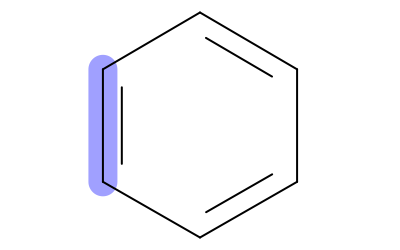
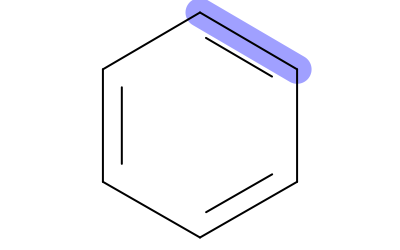
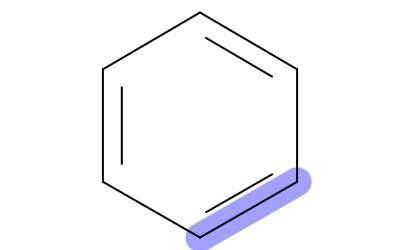
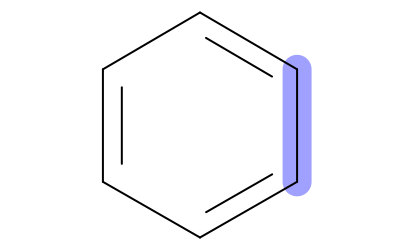
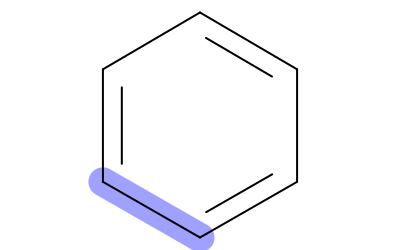
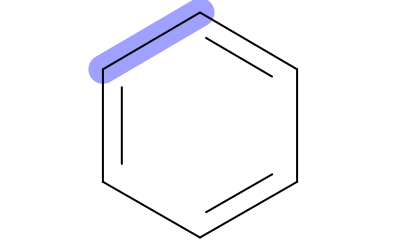
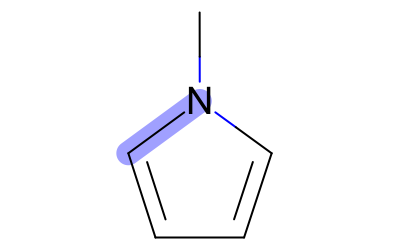
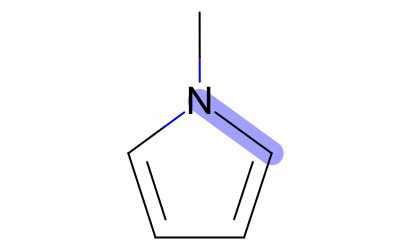
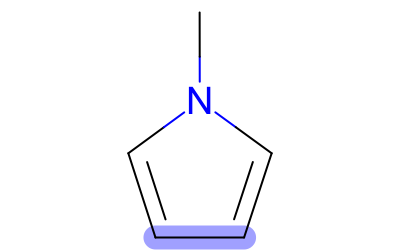
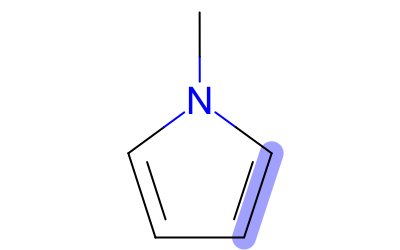
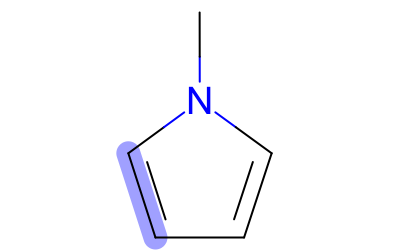
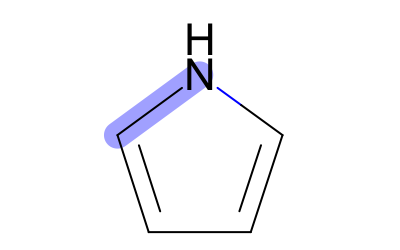
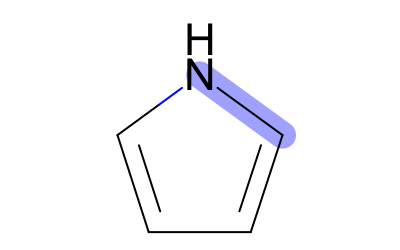
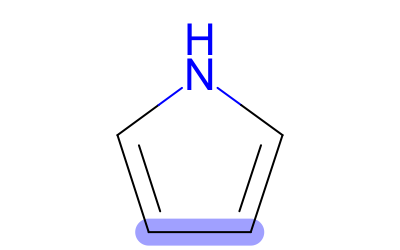
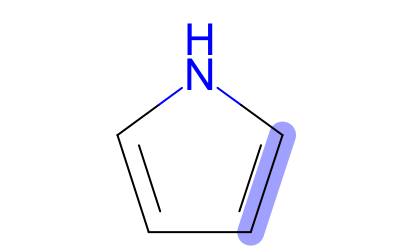
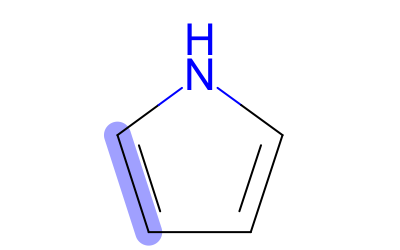
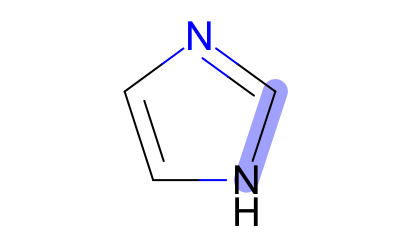
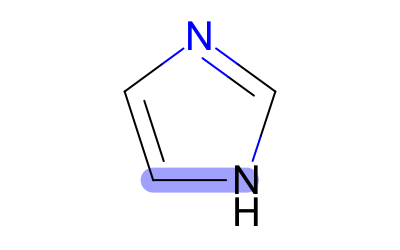
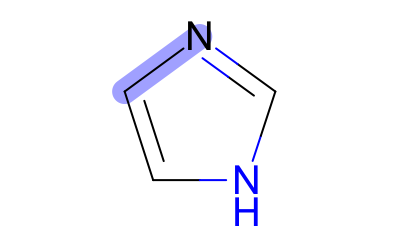
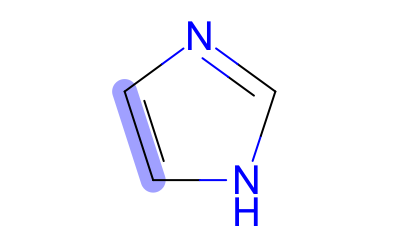
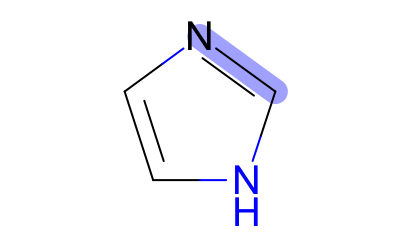
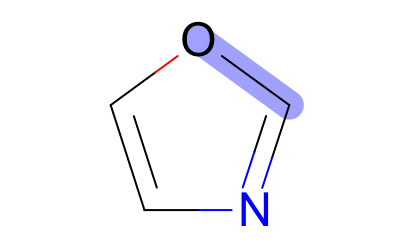
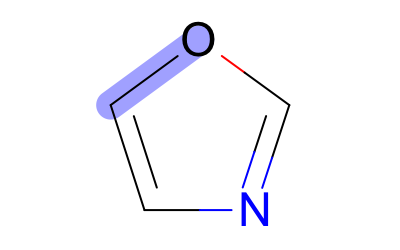
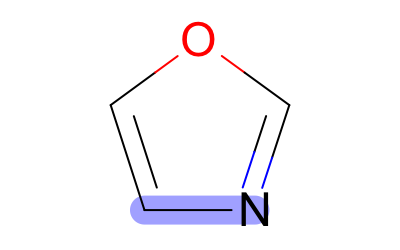
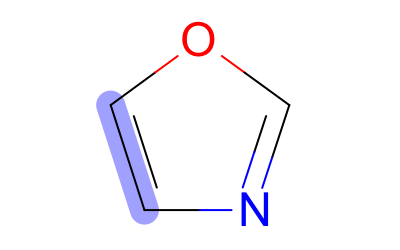
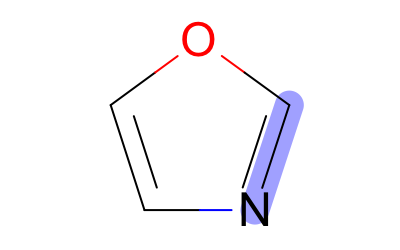
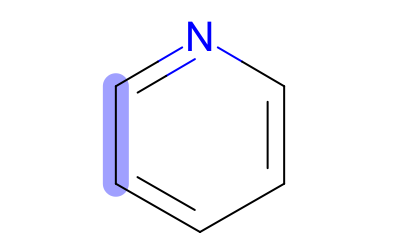
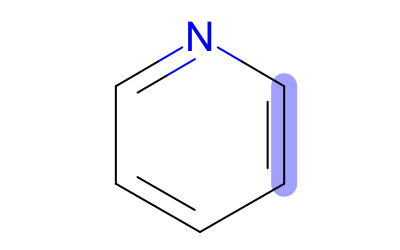
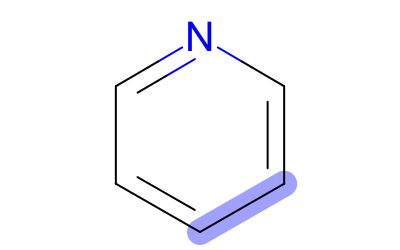
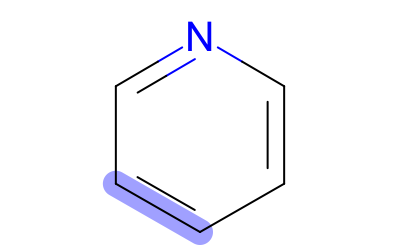
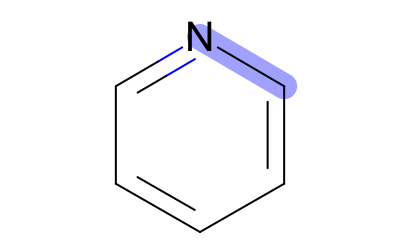
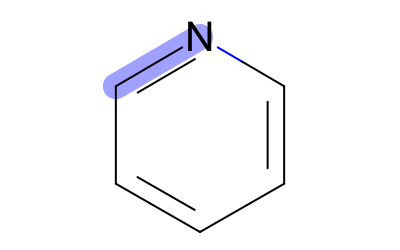

In [12]:
oenb.render_dataframe(df, render_func=depict_bridge)